# Question: Do critics really count? 

What insights can be we gain by examining ratings from professional (and non-professional) movie reviewers and box-office revenue?


# Data Understanding

I used data from the [Rotten Tomatoes](https://https://www.rottentomatoes.com/) movie review-aggregation webiste to investigate this question. 


* rt.movie_info.tsv.gz
    * Contains the synopses, film rating, genre(s), director, writer, theater release date, dvd release date, box office, runtime, and studio for select movies featured on the Rotten Tomatoes review-aggregation website.

* rt.reviews.tsv.gz
    * Contains movie review details for select movies featured on the Rotten Tomatoes review-aggregation website. Movie review details include, review text, critic rating, Rotten Tomatoes-assigned "fresh" score, critic name and "top critic" status, review publisher, and review date. Ratings are provided by various movie critics.

In [10]:
import pandas as pd
import numpy as np

# set up pandas to display floats in a more human friendly way
pd.options.display.float_format = '{:,.2f}'.format

__Read Error__

There are 1562 lines in rt.movie_info.tsv but I ran into a error upon read_csv(). Set the para 'error_bad_lines' to False so the bad lines would be skipped. 1560 lines/records were read in. So only 2 lines were dropped. 

In [11]:
rt_movie_info_df = pd.read_csv('../zippedData/rt.movie_info.tsv.gz', sep='\t', error_bad_lines=False, warn_bad_lines=True)
rt_movie_info_df.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


In [12]:
print(rt_movie_info_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB
None


In [13]:
rt_reviews_df = pd.read_csv('../zippedData/rt.reviews.tsv.gz', sep='\t', encoding='latin1', error_bad_lines=False, warn_bad_lines=True)
rt_reviews_df.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


In [14]:
print(rt_reviews_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB
None


# Data Preparation

__Data cleaning, dropping, conversion and merging details:__

* No duplicates in movie info dataframe.

* 9 duplicates from movie reviews dataframe --- dropped.

* Only 340 of 1560 records in rt.movie_info.tsv had non-null values for box_office. 

* The critic-provided 'ratings' values are on different scales. Drop this column and use Rotten Tomatoes Tomatometer rating, 'fresh'.

* Merge movie info and review dataframes on the 'id' column which identifies a single movie.

* Renaming columns for clarity ('rating' to 'film_rating')

* Setting NaNs in film_rating to 'NR' (for Not Rated)

* Pulling out Year from all date columns.

* Want 'box_office' as a numeric value. Convert from str to float.

* NaNs in 'box_office' and it is a str. Fill with 'UNKNOWN' and make new column 'box_office_numeric'.

    * These 'UNKNOWN's are converted as 0.0. Keep this in mind when plotting.
    
* Want 'runtime' as a numeric value. Convert from a str to int. 

* NaNs in 'runtime' and it is a str. Fill with 'UNKNOWN' and make new column 'runtime_numeric'.

    * These 'UNKNOWN's are converted as 0. Keep this in mind when plotting.



Check for duplicates in the data

In [15]:
rt_movie_info_dups = rt_movie_info_df[rt_movie_info_df.duplicated()]
print(len(rt_movie_info_dups))

0


Check for duplicates in the data and drop any duplicates, keeping first column

In [16]:
# Select duplicate rows except first occurrence based on all columns
rt_review_dups = rt_reviews_df[rt_reviews_df.duplicated()]
print(len(rt_review_dups))

9


In [17]:
rt_reviews_df.drop_duplicates()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"
...,...,...,...,...,...,...,...,...
54427,2000,The real charm of this trifle is the deadpan c...,NaN,fresh,Laura Sinagra,1,Village Voice,"September 24, 2002"
54428,2000,NaN,1/5,rotten,Michael Szymanski,0,Zap2it.com,"September 21, 2005"
54429,2000,NaN,2/5,rotten,Emanuel Levy,0,EmanuelLevy.Com,"July 17, 2005"
54430,2000,NaN,2.5/5,rotten,Christopher Null,0,Filmcritic.com,"September 7, 2003"


In [18]:
print(rt_reviews_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB
None


__Messy Ratings__ 

Critic-provided 'ratings' reveals that these values vary widely, using letter grades and numeric ratings of differing scales 2/4 vs 9/10. Ugh.

In [19]:
rt_reviews_df.rating.unique()

array(['3/5', nan, 'C', '2/5', 'B-', '2/4', 'B', '3/4', '4/5', '4/4',
       '6/10', '1/4', '8', '2.5/4', '4/10', '2.0/5', '3/10', '7/10', 'A-',
       '5/5', 'F', '3.5/4', 'D+', '1.5/4', '3.5/5', '8/10', 'B+', '9/10',
       '2.5/5', '7.5/10', '5.5/10', 'C-', '1.5/5', '1/5', '5/10', 'C+',
       '0/5', '6', '0.5/4', 'D', '3.1/5', '3/6', '4.5/5', '0/4', '2/10',
       'D-', '7', '1/10', '3', 'A+', 'A', '4.0/4', '9.5/10', '2.5',
       '2.1/2', '6.5/10', '3.7/5', '8.4/10', '9', '1', '7.2/10', '2.2/5',
       '0.5/10', '5', '0', '2', '4.5', '7.7', '5.0/5', '8.5/10', '3.0/5',
       '0.5/5', '1.5/10', '3.0/4', '2.3/10', '4.5/10', '4/6', '3.5',
       '8.6/10', '6/8', '2.0/4', '2.7', '4.2/10', '5.8', '4', '7.1/10',
       '5/4', 'N', '3.5/10', '5.8/10', 'R', '4.0/5', '0/10', '5.0/10',
       '5.9/10', '2.4/5', '1.9/5', '4.9', '7.4/10', '1.5', '2.3/4',
       '8.8/10', '4.0/10', '2.2', '3.8/10', '6.8/10', '7.3', '7.0/10',
       '3.2', '4.2', '8.4', '5.5/5', '6.3/10', '7.6/10', '8.1/10',
  

__Tomatometer as an alternative__ 

Rotten Tomatoes standardizes movie ratings by deeming that a movie is either fresh (good) or rotten (not that good). This is the 'fresh' column and it contains a string ("fresh"/"rotten").  

I'm opting to use their Tomatometer for rating a movie and to drop the critic-provided 'rating' column

Since there can be multiple 'fresh' ratings for a single movie. We want the average 'fresh' rating. In order to get the average fresh rating, convert "fresh"/"rotten" to 1/0 and get the average. A movie with all "fresh" will be have 1.0 average, all "rotten" will have 0.0 average...the average fresh rating will be between 0-1.


More details on the Tomatometer [here](https://www.rottentomatoes.com/about#whatisthetomatometer)

In [20]:
rt_reviews_df.drop(['rating'], axis=1, inplace=True)

In [21]:
rt_reviews_df['fresh_score'] = rt_reviews_df.apply(lambda row: 1 if row.fresh=='fresh' else 0, axis=1)
rt_reviews_df.head()

,id,review,fresh,critic,top_critic,publisher,date,fresh_score
0,3,A distinctly gallows take on contemporary fina...,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018",1
1,3,It's an allegory in search of a meaning that n...,rotten,Annalee Newitz,0,io9.com,"May 23, 2018",0
2,3,... life lived in a bubble in financial dealin...,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018",1
3,3,Continuing along a line introduced in last yea...,fresh,Daniel Kasman,0,MUBI,"November 16, 2017",1
4,3,... a perverse twist on neorealism...,fresh,NaN,0,Cinema Scope,"October 12, 2017",1


In [22]:
# sanity check on the average fresh score...all good
print(rt_reviews_df.groupby(['id'])['fresh_score'].mean())

id
3      0.63
5      0.78
6      0.56
8      0.75
10     0.46
       ... 
1996   0.67
1997   0.36
1998   1.00
1999   0.59
2000   0.47
Name: fresh_score, Length: 1135, dtype: float64


In [23]:
# performing an inner join on the id col of the two data frames 
rt_reviewed_movies_df = pd.merge(rt_reviews_df, rt_movie_info_df, on='id')
print(rt_reviewed_movies_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54432 entries, 0 to 54431
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            54432 non-null  int64 
 1   review        48869 non-null  object
 2   fresh         54432 non-null  object
 3   critic        51710 non-null  object
 4   top_critic    54432 non-null  int64 
 5   publisher     54123 non-null  object
 6   date          54432 non-null  object
 7   fresh_score   54432 non-null  int64 
 8   synopsis      54300 non-null  object
 9   rating        54346 non-null  object
 10  genre         54345 non-null  object
 11  director      48992 non-null  object
 12  writer        45206 non-null  object
 13  theater_date  53206 non-null  object
 14  dvd_date      53206 non-null  object
 15  currency      33310 non-null  object
 16  box_office    33310 non-null  object
 17  runtime       53594 non-null  object
 18  studio        40125 non-null  object
dtypes: i

In [24]:
# rename for clarity
rt_reviewed_movies_df = rt_reviewed_movies_df.rename(columns={"date": "review_date", "rating": "film_rating"})
rt_reviewed_movies_df['film_rating'].fillna('NR', inplace=True)
rt_reviewed_movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54432 entries, 0 to 54431
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            54432 non-null  int64 
 1   review        48869 non-null  object
 2   fresh         54432 non-null  object
 3   critic        51710 non-null  object
 4   top_critic    54432 non-null  int64 
 5   publisher     54123 non-null  object
 6   review_date   54432 non-null  object
 7   fresh_score   54432 non-null  int64 
 8   synopsis      54300 non-null  object
 9   film_rating   54432 non-null  object
 10  genre         54345 non-null  object
 11  director      48992 non-null  object
 12  writer        45206 non-null  object
 13  theater_date  53206 non-null  object
 14  dvd_date      53206 non-null  object
 15  currency      33310 non-null  object
 16  box_office    33310 non-null  object
 17  runtime       53594 non-null  object
 18  studio        40125 non-null  object
dtypes: i

In [25]:
# Pulling out Year, as an int, from the columns representing dates
rt_reviewed_movies_df['review_year'] = rt_reviewed_movies_df.apply(lambda row: int(row.review_date[-4:]), axis = 1)

In [26]:
rt_reviewed_movies_df['theater_year'] = rt_reviewed_movies_df.apply(lambda row: int(row.theater_date[-4:]) if type(row.theater_date) is str else 0, axis = 1)

In [27]:
rt_reviewed_movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54432 entries, 0 to 54431
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            54432 non-null  int64 
 1   review        48869 non-null  object
 2   fresh         54432 non-null  object
 3   critic        51710 non-null  object
 4   top_critic    54432 non-null  int64 
 5   publisher     54123 non-null  object
 6   review_date   54432 non-null  object
 7   fresh_score   54432 non-null  int64 
 8   synopsis      54300 non-null  object
 9   film_rating   54432 non-null  object
 10  genre         54345 non-null  object
 11  director      48992 non-null  object
 12  writer        45206 non-null  object
 13  theater_date  53206 non-null  object
 14  dvd_date      53206 non-null  object
 15  currency      33310 non-null  object
 16  box_office    33310 non-null  object
 17  runtime       53594 non-null  object
 18  studio        40125 non-null  object
 19  revi

In [28]:
# getting numeric box office vlaues
rt_reviewed_movies_df['box_office'].fillna('UNKNOWN', inplace=True)

In [29]:
rt_reviewed_movies_df['box_office_numeric'] = rt_reviewed_movies_df.apply(lambda row: 0 if row.box_office=='UNKNOWN' else int(row.box_office.replace(',','')), axis=1)
rt_reviewed_movies_df.head()

,id,review,fresh,critic,top_critic,publisher,review_date,fresh_score,synopsis,film_rating,...,writer,theater_date,dvd_date,currency,box_office,runtime,studio,review_year,theater_year,box_office_numeric
0,3,A distinctly gallows take on contemporary fina...,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018",1,"New York City, not-too-distant-future: Eric Pa...",R,...,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,2018,2012,600000
1,3,It's an allegory in search of a meaning that n...,rotten,Annalee Newitz,0,io9.com,"May 23, 2018",0,"New York City, not-too-distant-future: Eric Pa...",R,...,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,2018,2012,600000
2,3,... life lived in a bubble in financial dealin...,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018",1,"New York City, not-too-distant-future: Eric Pa...",R,...,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,2018,2012,600000
3,3,Continuing along a line introduced in last yea...,fresh,Daniel Kasman,0,MUBI,"November 16, 2017",1,"New York City, not-too-distant-future: Eric Pa...",R,...,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,2017,2012,600000
4,3,... a perverse twist on neorealism...,fresh,NaN,0,Cinema Scope,"October 12, 2017",1,"New York City, not-too-distant-future: Eric Pa...",R,...,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,2017,2012,600000


In [24]:
print(rt_reviewed_movies_df['box_office_numeric'].describe())

count        54,432.00
mean     32,528,122.65
std      59,919,239.16
min               0.00
25%               0.00
50%       3,400,000.00
75%      37,431,431.00
max     368,000,000.00
Name: box_office_numeric, dtype: float64


In [30]:
# getting numeric runtime values
rt_reviewed_movies_df['runtime'].fillna('UNKNOWN', inplace=True)

In [31]:
rt_reviewed_movies_df['runtime_numeric'] = rt_reviewed_movies_df.apply(lambda row: 0 if row.runtime=='UNKNOWN' else int(row.runtime.replace('minutes','')), axis=1)
rt_reviewed_movies_df.head()

,id,review,fresh,critic,top_critic,publisher,review_date,fresh_score,synopsis,film_rating,...,theater_date,dvd_date,currency,box_office,runtime,studio,review_year,theater_year,box_office_numeric,runtime_numeric
0,3,A distinctly gallows take on contemporary fina...,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018",1,"New York City, not-too-distant-future: Eric Pa...",R,...,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,2018,2012,600000,108
1,3,It's an allegory in search of a meaning that n...,rotten,Annalee Newitz,0,io9.com,"May 23, 2018",0,"New York City, not-too-distant-future: Eric Pa...",R,...,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,2018,2012,600000,108
2,3,... life lived in a bubble in financial dealin...,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018",1,"New York City, not-too-distant-future: Eric Pa...",R,...,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,2018,2012,600000,108
3,3,Continuing along a line introduced in last yea...,fresh,Daniel Kasman,0,MUBI,"November 16, 2017",1,"New York City, not-too-distant-future: Eric Pa...",R,...,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,2017,2012,600000,108
4,3,... a perverse twist on neorealism...,fresh,NaN,0,Cinema Scope,"October 12, 2017",1,"New York City, not-too-distant-future: Eric Pa...",R,...,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,2017,2012,600000,108


# Exploratory Data Analysis


After all that cleaning, let's get work!  

Let's explore if there is a relationship between a movie's average fresh rating (Tomatometer that is based off of critics' reviews) and it's box office performance?  Might a higher average fresh rating result in better box office numbers?

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
# just get the rows w/ a non-0 value for box office  
rt_boxoffice_df = rt_reviewed_movies_df.loc[rt_reviewed_movies_df['box_office_numeric'] != 0]
print(rt_boxoffice_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33310 entries, 0 to 54317
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  33310 non-null  int64 
 1   review              32157 non-null  object
 2   fresh               33310 non-null  object
 3   critic              32085 non-null  object
 4   top_critic          33310 non-null  int64 
 5   publisher           33104 non-null  object
 6   review_date         33310 non-null  object
 7   fresh_score         33310 non-null  int64 
 8   synopsis            33310 non-null  object
 9   film_rating         33310 non-null  object
 10  genre               33310 non-null  object
 11  director            29368 non-null  object
 12  writer              27634 non-null  object
 13  theater_date        33199 non-null  object
 14  dvd_date            33199 non-null  object
 15  currency            33310 non-null  object
 16  box_office          33

In [43]:
# for all movies that have a box office value, what is the average fresh_score?
print(rt_boxoffice_df.groupby(['id'])['fresh_score'].mean())

id
3      0.63
10     0.46
13     0.64
14     0.14
23     0.91
       ... 
1976   0.96
1980   0.82
1981   0.75
1986   0.98
1996   0.67
Name: fresh_score, Length: 299, dtype: float64


In [44]:
#hacky but works for scatter plotting purposes. :/
print(rt_boxoffice_df.groupby(['id'])['box_office_numeric'].min())
print(rt_boxoffice_df.groupby(['id'])['box_office_numeric'].max())

id
3         600000
10      41032915
13        224114
14        134904
23      99165609
          ...   
1976     1320005
1980    25335935
1981     1416189
1986      794306
1996    33886034
Name: box_office_numeric, Length: 299, dtype: int64
id
3         600000
10      41032915
13        224114
14        134904
23      99165609
          ...   
1976     1320005
1980    25335935
1981     1416189
1986      794306
1996    33886034
Name: box_office_numeric, Length: 299, dtype: int64


/home/user/anaconda3/envs/flatiron/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


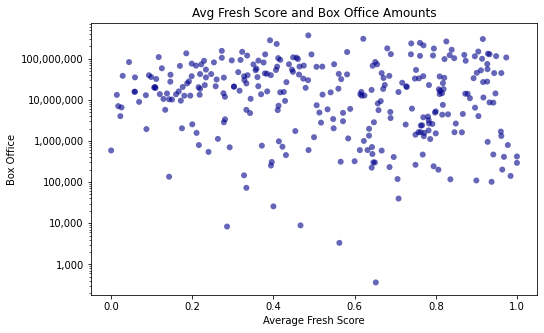

In [45]:
from matplotlib.ticker import StrMethodFormatter

x = rt_boxoffice_df.groupby(['id'])['fresh_score'].mean()
y = rt_boxoffice_df.groupby(['id'])['box_office_numeric'].min()

fig = plt.figure(figsize=(8, 5))
ax = plt.gca()
ax.scatter(x, y, c='darkblue', edgecolors='none', alpha=.60)
ax.set_yscale('log')
plt.axes().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.title('Avg Fresh Score and Box Office Amounts')
plt.xlabel('Average Fresh Score')
plt.ylabel('Box Office')
plt.show()

Hmm...nothing much to see here.  Let's get the correllation coefffient between a movie's average fresh score and it's box office gross.

In [46]:
np.corrcoef(x=rt_boxoffice_df.groupby(['id'])['fresh_score'].mean(), y=rt_boxoffice_df.groupby(['id'])['box_office_numeric'].min())

array([[1.        , 0.05424183],
       [0.05424183, 1.        ]])

As the scatterplot shows, a movie's average fresh score doesn't really correlate to it's box office gross.

In [47]:
#hacky but works for scatter plotting purposes :/
print(rt_boxoffice_df.groupby(['id'])['runtime_numeric'].min())
print(rt_boxoffice_df.groupby(['id'])['runtime_numeric'].max())

id
3       108
10       82
13      123
14      117
23      129
       ... 
1976    123
1980    119
1981    129
1986     97
1996    106
Name: runtime_numeric, Length: 299, dtype: int64
id
3       108
10       82
13      123
14      117
23      129
       ... 
1976    123
1980    119
1981    129
1986     97
1996    106
Name: runtime_numeric, Length: 299, dtype: int64


__BONUS ROUND__ aka I have clean data and I'm gonna use it! 


Let's explore a possible relationship between movie runtime and box office.

/home/user/anaconda3/envs/flatiron/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


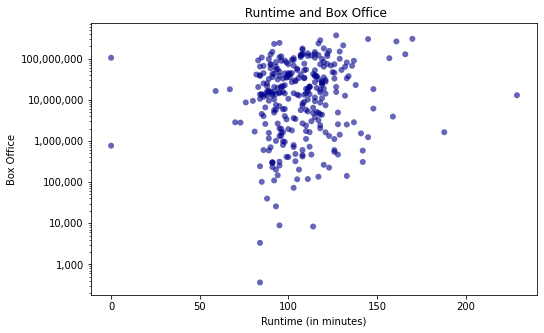

In [48]:
from matplotlib.ticker import StrMethodFormatter

x = rt_boxoffice_df.groupby(['id'])['runtime_numeric'].min()
y = rt_boxoffice_df.groupby(['id'])['box_office_numeric'].min()

fig = plt.figure(figsize=(8, 5))
ax = plt.gca()
ax.scatter(x, y, c='darkblue', edgecolors='none',  alpha=.60)
ax.set_yscale('log')
plt.axes().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.title(' Runtime and Box Office')
plt.xlabel('Runtime (in minutes)')
plt.ylabel('Box Office')
plt.show()

In [49]:
np.corrcoef(x=rt_boxoffice_df.groupby(['id'])['runtime_numeric'].min(), y=rt_boxoffice_df.groupby(['id'])['box_office_numeric'].min())

array([[1.        , 0.19157631],
       [0.19157631, 1.        ]])

And again, no conclusive relationship.

# Conclusions


* __No conclusive relationships identifed between critics' ratings (nor runtime) and box office amount.__  Recommend that the client not spend excessive effort/attention to critics. Sound advice for everyone.


# Next Steps/Future Work

* __Consider running again with more data.__ This data set is small. Only 340 movies had box office numbers. Also I did not check for the time span on this dataset due to time contraints. Take a look at this and see if we are looking at too narrow of a time frame. Either way, I'd like to run this again with more Rotten Tomatoes data.
* __Clean up the messy critics' ratings.__ Maybe the Tomatometer is not all it is hyped up to be?  I could come up with a way to standardize the messy reviews from the critics. (Note: I do not suggest the critics are messy...just their rating systems.)